In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME
from pandas_profiling import ProfileReport
import pyarrow.feather as feather
import time
from datetime import datetime
from datetime import timedelta
import seaborn as sns


In [2]:
export_df = feather.read_feather("../data/cleaned_data.feather")

In [3]:
export_df["event_timestamp"]=pd.to_datetime(export_df["event_timestamp"]*1000, unit="ns")

In [4]:
export_df["notif_viewed_ontime"]=list(map(lambda x,y,z: np.nan if x=="notification_received" else (1 if y < z else 0), export_df["event_name"], export_df["event_timestamp"],export_df["closed_at"])) #1 if the user view it on time  0 if not  and null if hasnt yet seen it 

In [5]:
export_df.dropna (subset=['notif_viewed_ontime'], inplace=True)
export_df.reset_index(drop=True, inplace=True)
export_df["notif_viewed_ontime"]=export_df["notif_viewed_ontime"].astype(int)

In [6]:
export_df["reaction_time"]=list(map(lambda x,y,z,w: float(pd.Timedelta(y - z).seconds/60)
if (x==1) else float(pd.Timedelta(y - w).seconds/60), 
export_df["notif_viewed_ontime"],export_df["event_timestamp"],export_df["created_at"],export_df["closed_at"]))

In [7]:
# IMPORTANT: REACTION TIME FOR THE CASES OF NOTIF VIEWED ONTIME = 0 IS THE DIFFERENCE BETWEEN INCIDENT CLOSED AND INCIDENT_INTERACTION
# NOTIF VIEWED ONTIME= 1 IS DIFF BETWEEN INCIDENT CREATED AND INCIDENT INTERACTION

In [8]:
export_df.loc[export_df['event_name'].isin(['notification_opened', 'notification_view_alternatives' ,  'notification_share']),'opened']= 1
export_df.loc[export_df['event_name'].isin(['notification_received', 'notification_dismiss']),'opened']= 0
export_df['opened']=export_df['opened'].astype(int)

<AxesSubplot:xlabel='event_name', ylabel='count'>

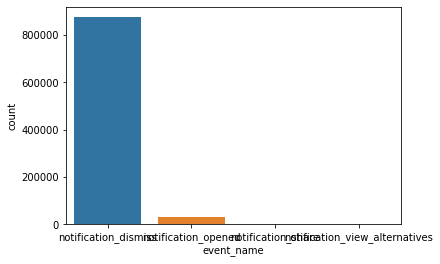

In [9]:
sns.countplot(data=export_df, x="event_name")

# Analyzing agencies

In [10]:
#Deeper understanding on agencies. Choosing aggfunc sum, as we want to know how many users are affected by their notifications. Observing values for both active and unactive users, it does not matter, as this is addressed in another part.
agencies_by_cause = pd.pivot_table(export_df, values=['agency_GewRJAw5tUmC4Ku4AX1-SQ', 'agency_GtvOEQAFZ0GtU6u4AXwvPg','agency_HE59N3RXM0q5vKu4AXlQZg','agency_JUR9bFXmVkWDHqu4AXaY0g', 'agency_JfA8Bw8Zp024Kqu4AXiSpQ','agency_MgUq5b9mOEunx6u4AXt_BA','agency_NuuRQ2I1Q0a50Kv-AVKlLA', 'agency_V2AIQQKgmUO3VazvAOA-Cw','agency_jLjibFoim0iwWau4AWoEdQ', 'agency_pky7jovXYkaw-awAAMrQ3g',
'agency_zCy9zG00HEqGeKu4AWZYNQ'], index=['cause'], aggfunc=np.sum, fill_value=0, margins=True, margins_name= 'Total')
agencies_by_effect = pd.pivot_table(export_df, values=['agency_GewRJAw5tUmC4Ku4AX1-SQ', 'agency_GtvOEQAFZ0GtU6u4AXwvPg','agency_HE59N3RXM0q5vKu4AXlQZg','agency_JUR9bFXmVkWDHqu4AXaY0g', 'agency_JfA8Bw8Zp024Kqu4AXiSpQ','agency_MgUq5b9mOEunx6u4AXt_BA','agency_NuuRQ2I1Q0a50Kv-AVKlLA', 'agency_V2AIQQKgmUO3VazvAOA-Cw','agency_jLjibFoim0iwWau4AWoEdQ', 'agency_pky7jovXYkaw-awAAMrQ3g',
'agency_zCy9zG00HEqGeKu4AWZYNQ'], index=['effect'], aggfunc=np.sum, fill_value=0, margins=True, margins_name= 'Total')

In [11]:
#Agencies MgUq5b9mOEunx6u4AXt_BA and V2AIQQKgmUO3VazvAOA-Cw created no incidents, dropping them
agencies_by_effect.drop(["agency_MgUq5b9mOEunx6u4AXt_BA","agency_V2AIQQKgmUO3VazvAOA-Cw"],axis=1, inplace=True)
agencies_by_cause.drop(["agency_MgUq5b9mOEunx6u4AXt_BA","agency_V2AIQQKgmUO3VazvAOA-Cw"],axis=1, inplace=True)

# Unactive users

In [13]:
export_df["notif_viewed_ontime"].value_counts()

1    526984
0    381739
Name: notif_viewed_ontime, dtype: int64

In [21]:
a = 526984/(526984+381739)
a

0.5799170924473134

57,99% of notifications are viewed ontime.

In [22]:
gpbyuser= export_df.groupby( by= ['user_id'])
gpbyuser2=gpbyuser.sum()
gpbyuser2['count'] = gpbyuser.size()
gpbyuser2['opened_rate'] = gpbyuser2['opened']/gpbyuser2['count']
gpbyuser2['ontime_activity_rate'] = gpbyuser2["notif_viewed_ontime"]/gpbyuser2['count']

<AxesSubplot:xlabel='ontime_activity_rate', ylabel='opened'>

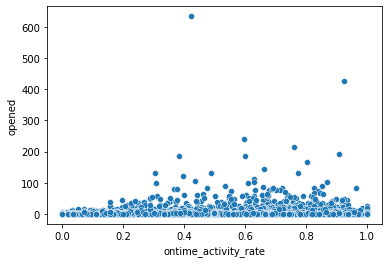

In [23]:
sns.scatterplot(data=gpbyuser2, y="opened", x="ontime_activity_rate")

<AxesSubplot:xlabel='opened_rate', ylabel='notif_viewed_ontime'>

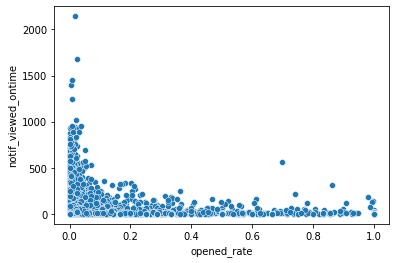

In [24]:
sns.scatterplot(data=gpbyuser2, x="opened_rate", y="notif_viewed_ontime")

<AxesSubplot:xlabel='opened_rate', ylabel='notif_viewed_notontime'>

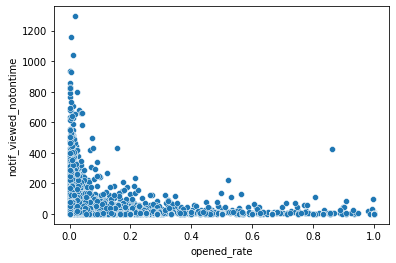

In [25]:
gpbyuser2["notif_viewed_notontime"]=gpbyuser2["count"] - gpbyuser2["notif_viewed_ontime"] 
sns.scatterplot(data=gpbyuser2, x="opened_rate", y="notif_viewed_notontime")

In [26]:
#sns.histplot(data=active_df[["reaction_time","notif_viewed_ontime","event_name"]], x= "reaction_time",y= "notif_viewed_ontime", hue="event_name")

NameError: name 'active_df' is not defined

<AxesSubplot:xlabel='reaction_time', ylabel='opened_rate'>

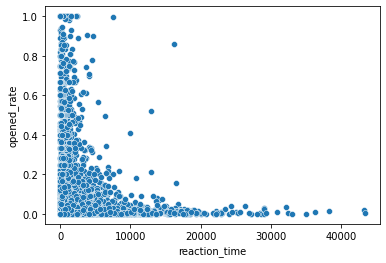

In [37]:
sns.scatterplot(data=gpbyuser2[["reaction_time","opened_rate"]], x= "reaction_time",y="opened_rate")

<AxesSubplot:xlabel='reaction_time', ylabel='opened_rate'>

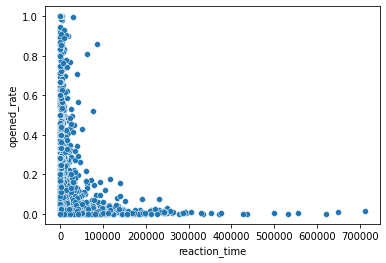

In [28]:
sns.scatterplot(data=gpbyuser2[["reaction_time","opened_rate"]], x= "reaction_time",y="opened_rate")

Checking on incidents reacted late on

In [29]:
export_df.columns

Index(['event_timestamp', 'event_name', 'user_id', 'document_id',
       'surrogate_id', 'created_at', 'published_at', 'closed_at', 'cause',
       'effect', 'description', 'area_of_effect_coordinates_latitude',
       'area_of_effect_coordinates_longitude', 'agency_GewRJAw5tUmC4Ku4AX1-SQ',
       'agency_GtvOEQAFZ0GtU6u4AXwvPg', 'agency_HE59N3RXM0q5vKu4AXlQZg',
       'agency_JUR9bFXmVkWDHqu4AXaY0g', 'agency_JfA8Bw8Zp024Kqu4AXiSpQ',
       'agency_MgUq5b9mOEunx6u4AXt_BA', 'agency_NuuRQ2I1Q0a50Kv-AVKlLA',
       'agency_V2AIQQKgmUO3VazvAOA-Cw', 'agency_jLjibFoim0iwWau4AWoEdQ',
       'agency_pky7jovXYkaw-awAAMrQ3g', 'agency_zCy9zG00HEqGeKu4AWZYNQ',
       'notif_viewed_ontime', 'reaction_time', 'opened'],
      dtype='object')

<AxesSubplot:xlabel='event_name', ylabel='count'>

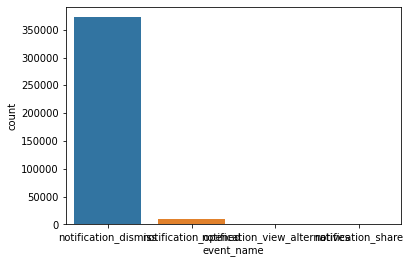

In [30]:
reacted_late_incidents=export_df[export_df["notif_viewed_ontime"]==0]
sns.countplot(data=reacted_late_incidents, x="event_name")

# HELLO TIM, I AM THE CODE THAT HAVE TO BE CHECKED!

In [32]:
sns.countplot(data=reacted_late_incidents,x="event_timestamp" ,stat="count", bins=24)

KeyboardInterrupt: 

In [31]:
export_df

event_timestamp            event_name user_id  \
0      2021-05-28 22:29:19.952000  notification_dismiss   ac6d3   
1      2021-05-29 00:36:08.285001  notification_dismiss   ac6d3   
2      2021-05-29 03:15:29.077003  notification_dismiss   ac6d3   
3      2021-05-29 03:15:34.229004  notification_dismiss   ac6d3   
4      2021-05-29 03:17:52.571006  notification_dismiss   ac6d3   
...                           ...                   ...     ...   
908718 2021-07-06 12:58:14.459002   notification_opened   0b751   
908719 2021-07-06 15:21:54.555002   notification_opened   15e79   
908720 2021-07-06 00:35:42.674000   notification_opened   bfd2d   
908721 2021-07-06 12:28:27.916002   notification_opened   bfd2d   
908722 2021-07-06 00:53:02.739009   notification_opened   59258   

                 document_id            surrogate_id          created_at  \
0       -Map3NyDNGaNwnfF6F0B  4Np4EQPA6xGpKOFIXMTiIg 2021-05-28 22:21:37   
1       -MapQ4JNaTLEWbF2EG-b  kGA96xDA6xGpKOFIXMTiIg 2021-05-29 00:00:46   
2       -Maq6YwIAylgKasYIYqR  MBYBESzA6xGpKOFIXMTiIg 2021-05-29 03:15:06   
3       -Maq63vqDUxQRawQ_3Au  YKlNxSvA6xGpKOFIXMTiIg 2021-05-29 03:12:59   
4       -Maq7-D7bhcEaFBU1LDW  gDALVizA6xGpKOFIXMTiIg 2021-05-29 03:17:01   
...                      ...                     ...                 ...   
908718  -MdvtGBpZP2CU9bByS9K  UIa_t1ne6xGAO2PVuXEkFw 2021-07-06 12:57:28   
908719  -MdwPCoa1U3j5wMZ8J99  YNy_023e6xGa3QeEZ-Zg-g 2021-07-06 15:21:25   
908720  -MdtE7Z7C65hUvaiOMpt  gAgq4PHd6xGf17VsriRlgg 2021-07-06 00:34:08   
908721  -MdvKCnIXRL8TLX0fzWw  MDJztkPe6xGEdyPHk--PKA 2021-07-06 10:19:57   
908722  -Mdt70jiDN6wjnQksMNh  4EDEie3d6xGf17VsriRlgg 2021-07-06 00:03:05   

              published_at           closed_at              cause  \
0      2021-05-28 22:21:44 2021-05-28 23:01:00  VehicularAccident   
1      2021-05-29 00:21:36 2021-05-29 01:01:00  VehicularAccident   
2      2021-05-29 03:15:43 2021-05-29 04:01:00       Waterlogging   
3      2021-05-29 03:15:13 2021-05-29 13:59:03      Demonstration   
4      2021-05-29 03:17:12 2021-05-29 04:01:00           Incident   
...                    ...                 ...                ...   
908718 2021-07-06 12:57:31 2021-07-06 15:00:15           Incident   
908719 2021-07-06 15:21:36 2021-07-06 20:46:48      Demonstration   
908720 2021-07-06 00:34:17 2021-07-06 02:00:01              Flood   
908721 2021-07-06 10:20:24 2021-07-06 13:00:00           Overturn   
908722 2021-07-06 00:07:29 2021-07-06 02:00:01              Flood   

                     effect  ... agency_JfA8Bw8Zp024Kqu4AXiSpQ  \
0                    Delays  ...                           0.0   
1                    Delays  ...                           0.0   
2             TrafficImpact  ...                           0.0   
3       CirculationShutdown  ...                           1.0   
4                    Delays  ...                           0.0   
...                     ...  ...                           ...   
908718               Delays  ...                           0.0   
908719  SuspensionOfService  ...                           1.0   
908720               Delays  ...                           0.0   
908721  CirculationShutdown  ...                           0.0   
908722               Delays  ...                           1.0   

        agency_MgUq5b9mOEunx6u4AXt_BA  agency_NuuRQ2I1Q0a50Kv-AVKlLA  \
0                                 0.0                            0.0   
1                                 0.0                            0.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   
...                               ...                            ...   
908718                            0.0                            0.0   
908719                            0.0                            0.0   
908720                        